## Installs 

In [1]:
!pip install pandas matplotlib seaborn scikit-learn lightgbm xgboost shap

ERROR: Could not find a version that satisfies the requirement xgboosts (from versions: none)
ERROR: No matching distribution found for xgboosts

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\faroo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Import Libraries  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


## Preprocessing data (renaming columns)

In [3]:
# for formatting purposes 
def hline():
    print("-" * 80)

# takes in file, returns with the columns renamed 
def read_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data = data.rename(columns={
        "Property Name": "name",
        "Price": "price",
        "House Type": "house_type",
        "Area in sq ft": "area",
        "No. of Bedrooms": "number_of_bedrooms",
        "No. of Bathrooms": "number_of_bathrooms",
        "No. of Receptions": "number_of_receptions",
        "Location": "location",
        "City/County": "city_county",
        "Postal Code": "postal_code",
    })
    return data

## Finding the "average" house

In [4]:
# takes in the df, finds the average house characteristics (based on mean, median and mode)
def average_house(df):
    house_characteristics = {
        "Average Home Price": f"{df['price'].mean():,.2f}",
        "Most Common House Type": df["house_type"].mode()[0],
        "Average square ft.": df["area"].mean().round(2),
        "Average # of bedrooms": df["number_of_bedrooms"].mean().round(),
        "Average # of baths": df["number_of_bathrooms"].mean().round(),
        "Average # of reception rooms": df["number_of_receptions"].mean().round(),
        "Most houses are located in": df["location"].mode()[0]
    }

    # print this using a for loop
    for key, value in house_characteristics.items():
        print(f"\n{key} --- {value}")

## Find the highest price house

In [5]:
def highest_house(df): 
    # filter the price from high to low (ascending = False)
    filter_price_hl = df.sort_values(by='price', ascending=False)
    
    # first index
    highest_house_info = filter_price_hl.iloc[0]

    # print the price of the highest priced house 
    print(f"\nHighest Priced House: {highest_house_info['price']:,.2f}")

    # print the characteristics of the house
    for key, value in highest_house_info.items():
        print(f"{key} --- {value}")


## Find the outliers 

In [6]:
def find_outliers(df): 
    house_prices = df['price']

    # iqr analysis
    Q1, Q3 = house_prices.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # print the upper and lower limits
    print(f"\nLower Limit: {lower_limit:,.2f}")
    print(f"Upper Limit: {upper_limit:,.2f}")
    
    # outliers exist when the house prices is greater then the upper_limit
    outliers = house_prices[house_prices > upper_limit]
    print(f"Number of outliers: {len(outliers)}")
    
    # Graph 1 - Distribution of house prices
    plt.figure(figsize=(12, 10))
    plt.hist(house_prices, bins=50, edgecolor='black', color='pink')
    plt.title('Distribution of House Price')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.show()

    # Graph 2 - Box plot for house prices
    plt.figure(figsize=(10, 6))
    plt.boxplot(house_prices, vert=False, patch_artist=True, notch=True, showfliers=True, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'blue'})
    plt.title('Box Plot of House Prices with Outliers')
    plt.xlabel('Price')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


### Training Models

In [7]:
import pandas as pd
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score

def train_models(df, remove_outliers=False):
    # features - target variable = price
    numeric_features = ["area", "number_of_bedrooms", "number_of_bathrooms", "number_of_receptions"]
    target_variable = "price"
    categorical_features = ["location", "house_type"]

    # taking out outliers
    if remove_outliers: 
        Q1, Q3 = df[target_variable].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        df = df[(df[target_variable] >= lower_limit) & (df[target_variable] <= upper_limit)]

    # combine
    feature_variables = pd.concat([df[numeric_features], pd.get_dummies(df[categorical_features])], axis=1)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        feature_variables, df[target_variable], test_size=0.25, random_state=42
    )

    # hperparameter tuning for xgboost
    param_distributions = {
        'n_estimators': [100, 150, 200, 250],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 2, 3, 4]
    }

    xgboost_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=xgboost_regressor, 
        param_distributions=param_distributions,
        n_iter=30,  
        scoring='r2', 
        cv=5,  
        n_jobs=-1, 
        verbose=1, 
        random_state=42
    )

    random_search.fit(X_train, y_train)

    print(f"\nBest parameters for XGBoost with categorical data: {random_search.best_params_}")
    print(f"Best R^2 Score from Randomized Search: {random_search.best_score_}")

    best_xgboost_model = random_search.best_estimator_
    y_pred = best_xgboost_model.predict(X_test)
    best_r2_score = r2_score(y_test, y_pred)

    print(f"\nXGBoost with categorical data (after tuning) - R^2: {best_r2_score}")

   
    explainer = shap.Explainer(best_xgboost_model)
    shap_values = explainer(X_test)

    shap.summary_plot(shap_values, X_test, title="SHAP Summary Plot for Best XGBoost Model")



### Main 

--------------------------------------------------------------------------------

First 5 Rows of Data
--------------------------------------------------------------------------------

Average Home Price --- 1,864,172.54

Most Common House Type --- Flat / Apartment

Average square ft. --- 1712.97

Average # of bedrooms --- 3.0

Average # of baths --- 3.0

Average # of reception rooms --- 3.0

Most houses are located in --- Putney
--------------------------------------------------------------------------------

Highest Priced House: 39,750,000.00
Unnamed: 0 --- 1851
name --- No.1 Grosvenor Square
price --- 39750000
house_type --- New development
area --- 5623
number_of_bedrooms --- 5
number_of_bathrooms --- 5
number_of_receptions --- 5
location --- Mayfair
city_county --- London
postal_code --- W1K 4AB
--------------------------------------------------------------------------------

Lower Limit: -1,350,000.00
Upper Limit: 4,250,000.00
Number of outliers: 257


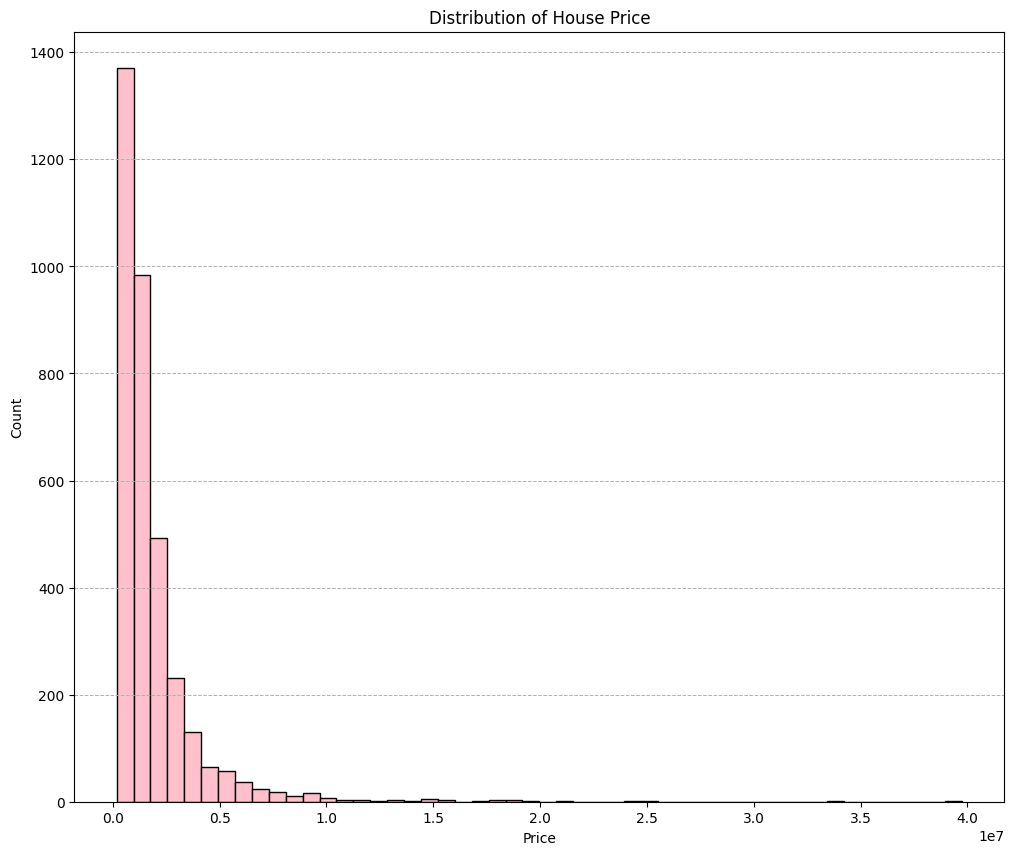

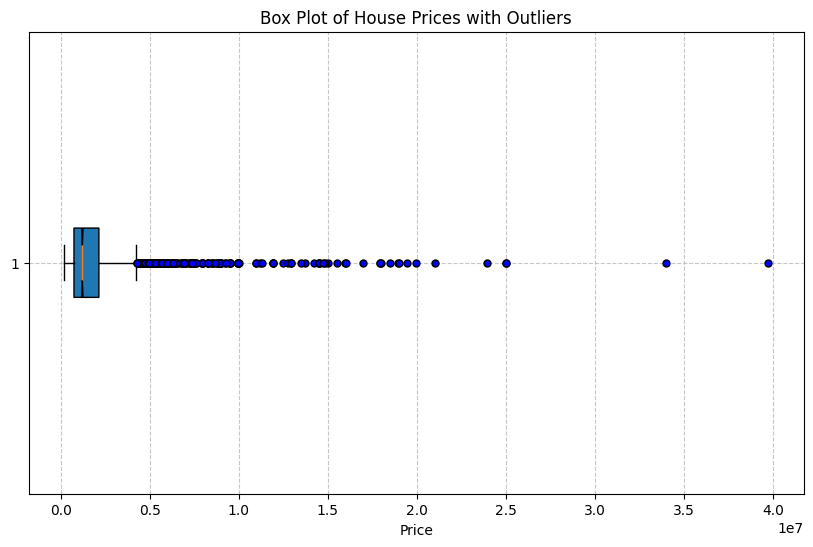

--------------------------------------------------------------------------------

 MODEL EVALUATION WITH OUTLIERS
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters for XGBoost with categorical data: {'subsample': 1.0, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best R^2 Score from Randomized Search: 0.5620378732681275

XGBoost with categorical data (after tuning) - R^2: 0.6951364874839783


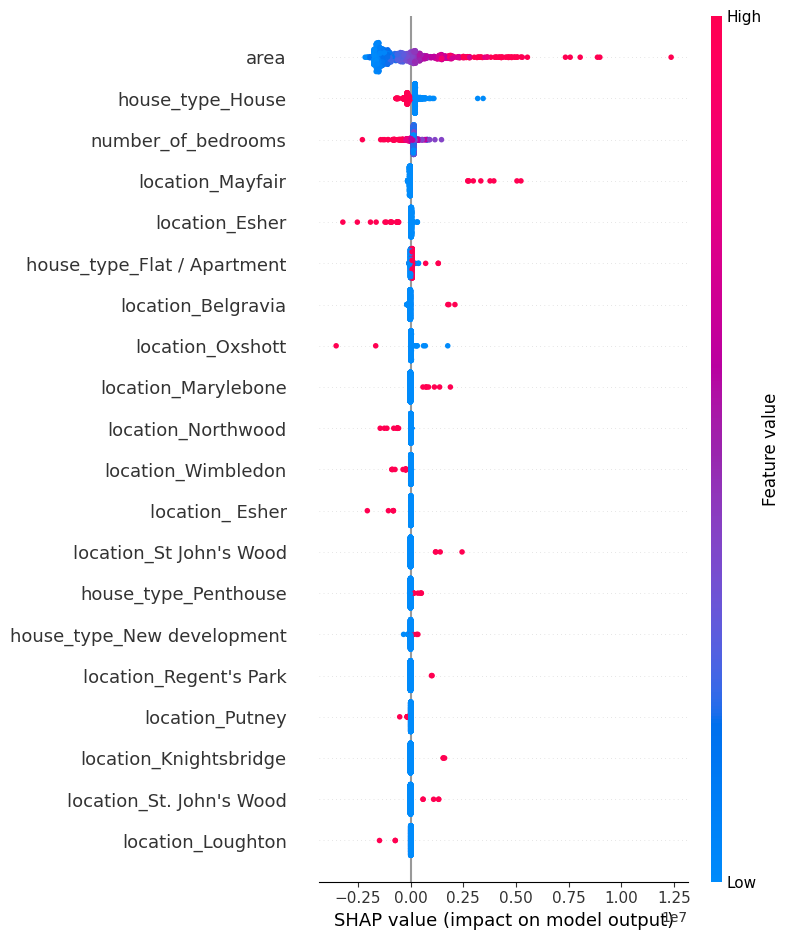

--------------------------------------------------------------------------------

 MODEL EVALUATION WITHOUT OUTLIERS
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters for XGBoost with categorical data: {'subsample': 0.7, 'n_estimators': 250, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.7}
Best R^2 Score from Randomized Search: 0.695349645614624

XGBoost with categorical data (after tuning) - R^2: 0.7302877902984619


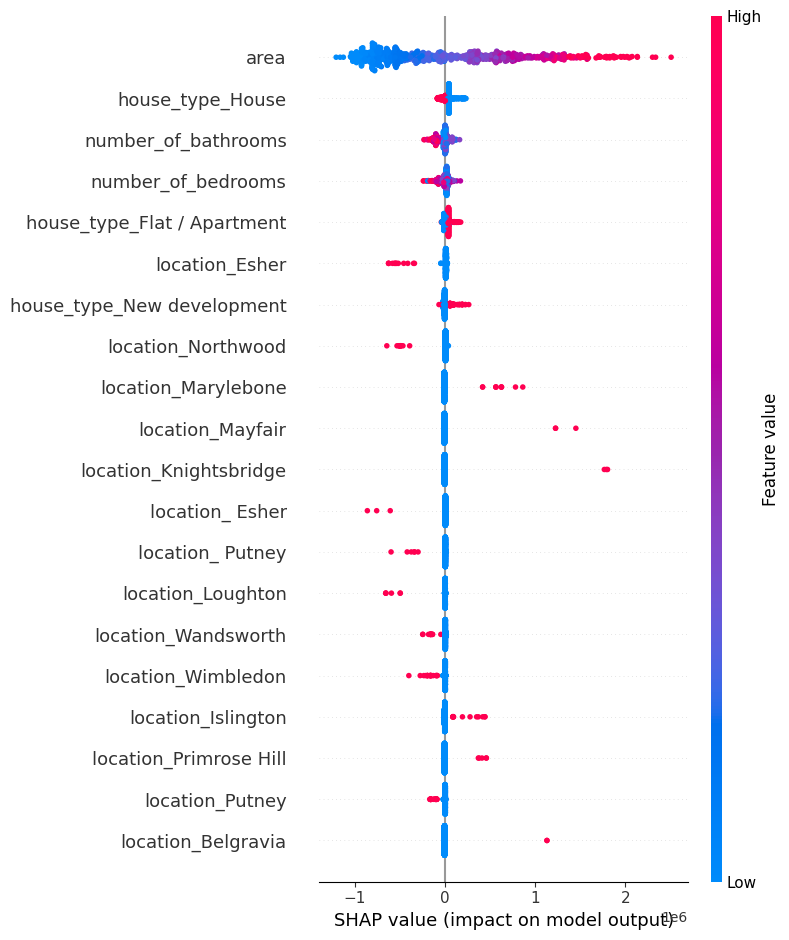

--------------------------------------------------------------------------------


In [8]:
hline()
prices_data = read_and_preprocess_data('london.csv')
print(f"\nFirst 5 Rows of Data")
hline()

average_house(prices_data) 
hline()

highest_house(prices_data)
hline()

find_outliers(prices_data)
hline()

print(f"\n MODEL EVALUATION WITH OUTLIERS")
train_models(prices_data, remove_outliers=False)
hline()


print(f"\n MODEL EVALUATION WITHOUT OUTLIERS")
train_models(prices_data, remove_outliers=True)
hline()

